# Простейший генератор новообразований (nodule, tumor, lesionfrom PIL import Image

Jupyter notebook для демонстрации и отладки алгоритма

Алгоритм заключается в 
1. Генерации случайного замкнутого контура
2. Масштабировании под нужный размер
3. Наложении контура с шумами исходного изображения на исходное изображение здоровых лёгких

In [12]:
from PIL import Image
import numpy as np
from sklearn.preprocessing import minmax_scale
import pydicom
from pydicom import dcmread
from pydicom.data import get_testdata_files, get_testdata_file
from scipy.special import binom
import matplotlib.pyplot as plt
%matplotlib widget

## Извлечение матрицы изображения из DICOM с пресетом Lung

In [21]:
# def image_from_dicom(filename, wc = 0, ww = 1500, dtype=np.uint8):
#     dicom_file = dcmread(filename)
#     image_matrix = dicom_file.pixel_array

#     orig_shape = image_matrix.shape
#     print("min = ", image_matrix.min())
#     print("max = ", image_matrix.max())

#     # выделение к окна wc/ww (засветка и затемнение прочих частей матрицы)

#     lung_brightness_lower = wc - ww/2
#     lung_brightness_upper = wc + ww/2

#     image_matrix[image_matrix < lung_brightness_lower] = lung_brightness_lower
#     image_matrix[image_matrix > lung_brightness_upper] = lung_brightness_upper

#     # нормализация под диапазон обычного изображения (0,255)
#     # normalized_matrix = minmax_scale(image_matrix.flatten(), feature_range=(0,65535))
#     normalized_matrix = minmax_scale(image_matrix.flatten(), feature_range=(0,255))
#     displayed_matrix_8bit = normalized_matrix.reshape(orig_shape).astype(dtype=dtype)
#     # print("min = ", displayed_matrix_8bit.min())
#     # print("max = ", displayed_matrix_8bit.max())
#     return displayed_matrix_8bit

def image_from_dicom(filename, wc = 0, ww = 1500, dtype=np.uint8):
    dicom_file = dcmread(filename)
    image_matrix = dicom_file.pixel_array

    # orig_shape = image_matrix.shape
    # print("min = ", image_matrix.min())
    # print("max = ", image_matrix.max())

    # выделение к окна wc/ww (засветка и затемнение прочих частей матрицы)

    # lung_brightness_lower = wc - ww/2
    # lung_brightness_upper = wc + ww/2

    # image_matrix[image_matrix < lung_brightness_lower] = lung_brightness_lower
    # image_matrix[image_matrix > lung_brightness_upper] = lung_brightness_upper

    # нормализация под диапазон обычного изображения (0,255)
    # normalized_matrix = minmax_scale(image_matrix.flatten(), feature_range=(0,65535))
    # normalized_matrix = minmax_scale(image_matrix.flatten(), feature_range=(0,255))
    # displayed_matrix_8bit = normalized_matrix.reshape(orig_shape).astype(dtype=dtype)
    return image_matrix

filename = "1-18.dcm"
displayed_matrix = image_from_dicom(filename=filename, wc=0)
# displayed_matrix
pil_image = Image.fromarray(displayed_matrix, 'I;16')
# pil_image = Image.fromarray(np.uint8(ds.displayed_matrix_16bit),mode="I:16")
display(pil_image)

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)

## Извлечение матрицы шума

In [14]:
import cv2
import numpy as np

denoise_h = 5
denoise_swindow_size = 6
denoise_block_size = 7

# Источник https://docs.opencv.org/4.x/d1/d79/group__photo__denoise.html#ga76abf348c234cecd0faf3c42ef3dc715
denoised_3px = cv2.fastNlMeansDenoising(
    displayed_matrix_8bit,
    None,
    denoise_h) #Parameter regulating filter strength
#     denoise_swindow_size, # Size in pixels of the window that is used to compute weighted average for given pixel. Should be odd
#     denoise_block_size, # Size in pixels of the template patch that is used to compute weights
# )

display(Image.fromarray(displayed_matrix_8bit))

denoised_5px = cv2.fastNlMeansDenoising(displayed_matrix_8bit, None, 5)
denoised_7px = cv2.fastNlMeansDenoising(displayed_matrix_8bit, None, 7)
denoised_9px = cv2.fastNlMeansDenoising(displayed_matrix_8bit, None, 9)
denoised_11px = cv2.fastNlMeansDenoising(displayed_matrix_8bit, None, 11)

display(Image.fromarray(denoised_11px))

# получение матриц шумов как разности оригинального и сглаженного изображения
# диапазон расширен до int16 т.к. шумы могут быть отрицательные по знаку
noise_matrix_3px_int16 = np.subtract(displayed_matrix_8bit.astype(np.int16), denoised_3px.astype(np.int16))
noise_matrix_7px_int16 = np.subtract(displayed_matrix_8bit.astype(np.int16), denoised_7px.astype(np.int16))
noise_matrix_11px_int16 = np.subtract(displayed_matrix_8bit.astype(np.int16), denoised_11px.astype(np.int16))

print("max noise 3px = ", noise_matrix_3px_int16.max())
print("min noise 3px = ", noise_matrix_3px_int16.min())

print("max noise 7px = ", noise_matrix_7px_int16.max())
print("min noise 7px = ", noise_matrix_7px_int16.min())

print("max noise 11px = ", noise_matrix_11px_int16.max())
print("min noise 11px = ", noise_matrix_11px_int16.min())

# display(Image.fromarray(noise_matrix_11px_int16))

NameError: name 'displayed_matrix_8bit' is not defined

## Генерация замкнутого 2D-контура

In [15]:
# Источник https://stackoverflow.com/a/50751932/12691808
# Альтернативный алгоритм генерации https://stackoverflow.com/a/71904002/12691808
# Альтернативный алгоритм генерации https://stackoverflow.com/a/71875698/12691808

bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points. 
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)


shape =  (480, 640)


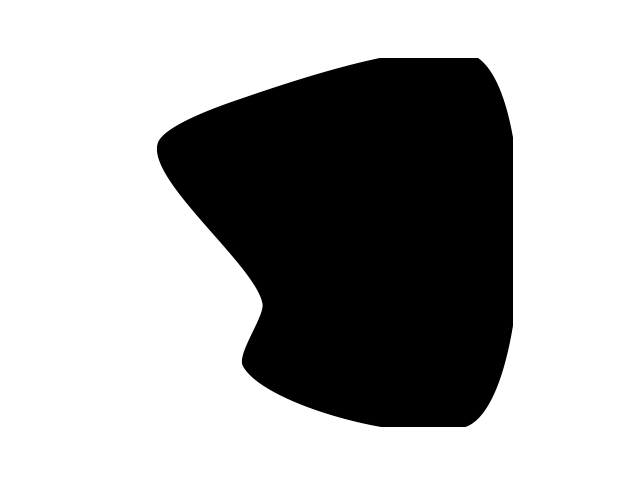

In [16]:
from matplotlib.backends.backend_agg import FigureCanvasAgg
def filled_random_contour(n, scale = 1, rad = 0.2, edgy = 0.05):
    """
    Создание случайного замкнутого заполненного контура
    Возвращает бинарный массив - маску
    
    Args:
        n - кол-во точек
        scale - масштаб
        rad - см. https://stackoverflow.com/a/50751932/12691808
        edgy - см. https://stackoverflow.com/a/50751932/12691808
    """
    a = get_random_points(n=n, scale=scale)
    x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
    fig = plt.figure()
    plt.gca().set_aspect("equal")
    plt.fill(x,y, color="black")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    # plt.tight_layout()
    plt.box(False)
    plt.tick_params(
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,
        top=False,         # ticks along the top edge are off
        labelbottom=False, # labels along the bottom edge are off
        labelleft=False)
    # plt.show()
    # plt.grid()
    canvas = plt.gcf().canvas
    agg = canvas.switch_backends(FigureCanvasAgg)
    agg.draw()
    result_array = np.asarray(agg.buffer_rgba())
    result_array = result_array[:,:,1]
    return result_array

random_contour = filled_random_contour(6)
im = Image.fromarray(random_contour)
print("shape = ", random_contour.shape)
display(im)

## Неравномерное размытие контура

### Генерация случайного Гауссового поля, задающего размытие

DIPlib -- a quantitative image analysis library
Version 3.3.0 (May 21 2022)
For more information see https://diplib.org


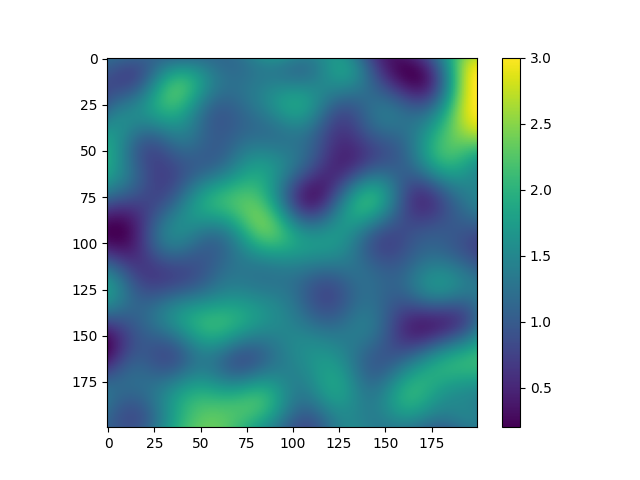

In [17]:
# подготовка случайной карты размытия

from gstools import SRF, Gaussian
import diplib as dip

def create_GRF_mask(shape, rng = (0.2,3.0), scale = 20, seed = 20170519):
    """
    
    Args:
        shape: кортеж (ширина, высота) изображения/карты
        rng: кортеж (мин, макс) значение карты
        scale - масштаб
    """
    # x = img.Sizes()[0]
    # y = img.Sizes()[1]
    x = shape[0]
    y = shape[1]
    shape = (range(x),range(y))
    model = Gaussian(dim=2, var=1.0, len_scale=scale)
    srf = SRF(model, seed=seed)
    blur_map = srf.structured(shape)
    blur_map = minmax_scale(blur_map.flatten().astype(float), feature_range=rng)
    blur_map = blur_map.reshape([x, y]) #.astype(dtype=np.uint8)
    # blur_map = blur_map * 2 + 1
    return blur_map

img = dip.ImageRead('1.jpg')
blur_map = create_GRF_mask(img.Sizes())
fig = plt.figure()
plt_image = plt.imshow(blur_map)
plt.colorbar(plt_image, ax=plt.gca())

### Визуализация Гауссового размытия с динамически изменяемым ядром

Величина размытия задаётся полем из предыдущей ячейки

Визуализация на наглядном тестовом клетчатом поле

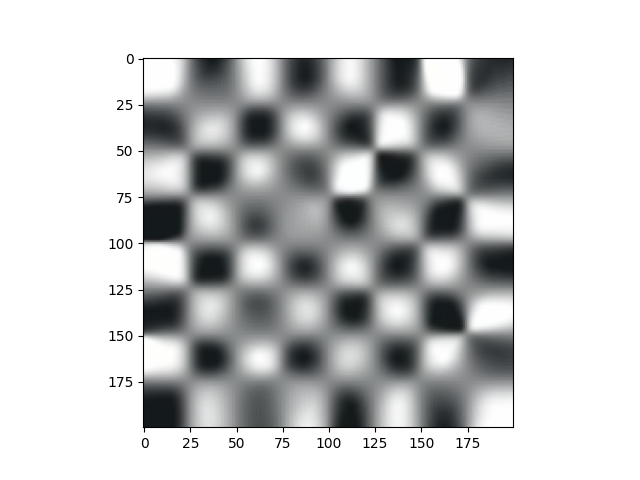

In [18]:
# Источник https://stackoverflow.com/questions/72750870/how-to-improve-a-variable-lens-blur-algorithm-in-python-opencv

# !pip install diplib
# !pip install gstools

import diplib as dip

# тестовое клетчатое поле
img = dip.ImageRead('1.jpg')
blur_map = create_GRF_mask(shape=(img.Sizes()[1], img.Sizes()[0]), rng = (0.1,3.0), scale = 20, seed = 20170519)
# пример маски из tutorial
# blur_map = dip.CreateRadiusSquareCoordinate(img.Sizes())
# blur_map /= dip.Maximum(blur_map)
# blur_map

# визуализация маски для теста
# fig = plt.figure()
# plt_image = plt.imshow(blur_map)
# plt.colorbar(plt_image, ax=plt.gca())

img_blur = dip.AdaptiveGauss(img, [0, blur_map], sigmas=[5])
# np.asarray(img_blur)
# img_blur.Show()
fig = plt.figure()
plt.imshow(np.asarray(img_blur, dtype=np.uint8))

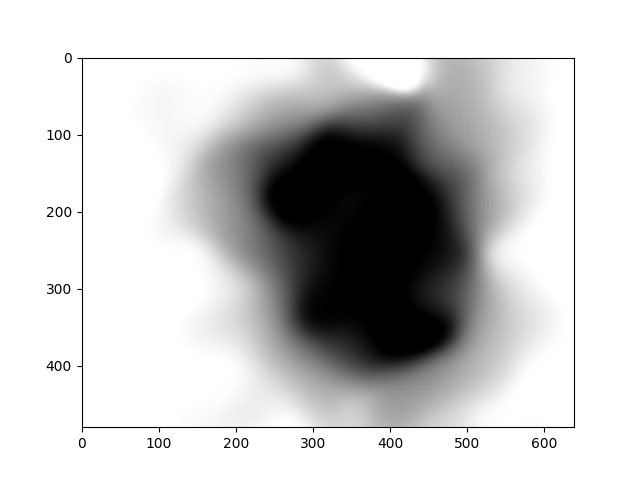

In [19]:
# размытие контура новообразования

img = dip.Image(random_contour)
blur_map = create_GRF_mask(shape=(img.Sizes()[1], img.Sizes()[0]), rng = (0.1, 10.0), scale=50)
# fig = plt.figure()
# plt_image = plt.imshow(blur_map)
# plt.colorbar(plt_image, ax=plt.gca())

img_blur = dip.AdaptiveGauss(img, [0, blur_map], sigmas=[11])
# np.asarray(img_blur)
# img_blur.Show()
fig = plt.figure()
plt.imshow(np.asarray(img_blur, dtype=np.uint8), cmap=plt.cm.gray)

## Наложение контура на исходное изображение

image_shift =  -2000
blurred =  0 254
flatten =  0 254
minmax_scale =  0.0 1500.0
reshape =  [[1500 1500 1500 ... 1500 1500 1500]
 [1500 1500 1500 ... 1500 1500 1500]
 [1500 1500 1500 ... 1500 1500 1500]
 ...
 [1500 1500 1500 ... 1500 1500 1500]
 [1500 1500 1500 ... 1500 1500 1500]
 [1500 1500 1500 ... 1500 1500 1500]]
2 =  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3 =  [[0 0 0 ... 5 0 0]
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 2 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
4 =  [[0 0 0 ... 4 0 0]
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


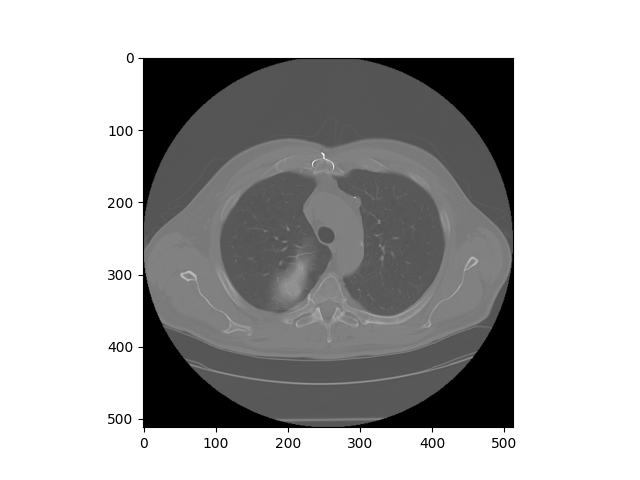

In [71]:
def add_nodule(src, coord=(150, 250), size=(100,100)):
    """
    Args:
        src - исходное изображение (numpy array)
        coord - координаты (x, y) центра узла, пиксели, от левого верхнего угла
        size - размеры узла, пиксели, (ширина, высота)
    """
    wc = 0 # центр окна яркости опухоли
    ww = 1500  # ширина окна яркости опухоли
    image_shift = src.min()
    print("image_shift = ", image_shift)
    image_begin =  wc - ww / 2
    image_end =  wc + ww / 2
    
    random_contour_nparray = filled_random_contour(n=7, scale = 1, rad = 0.2, edgy = 0.05)
    orig_shape = random_contour_nparray.shape
    # plt.figure()
    # plt.imshow(random_contour_nparray, cmap=plt.cm.gray)
    GRF_mask_nparray = create_GRF_mask(random_contour_nparray.shape, rng = (0.1,10.0), scale = 50)
    random_contour_blurred_diplib = dip.AdaptiveGauss(random_contour_nparray, [0, GRF_mask_nparray], sigmas=[11])
    random_contour_blurred_array = np.asarray(random_contour_blurred_diplib, dtype=np.int16)
    print("blurred = ", random_contour_blurred_array.min(), random_contour_blurred_array.max())
    random_contour_blurred_array = random_contour_blurred_array.flatten()
    print("flatten = ", random_contour_blurred_array.min(), random_contour_blurred_array.max())
    random_contour_blurred_array = minmax_scale(random_contour_blurred_array, feature_range=(0, ww))
    print("minmax_scale = ", random_contour_blurred_array.min(), random_contour_blurred_array.max())
    random_contour_blurred_array = random_contour_blurred_array.reshape(orig_shape).astype(dtype=np.int16)
    print("reshape = ", random_contour_blurred_array)
    #TODO вписать сгенерированный контур в size
    # random_contour_blurred_array = np.invert(random_contour_blurred_array)
    random_contour_blurred_array = random_contour_blurred_array.max() - random_contour_blurred_array
    print("2 = ", random_contour_blurred_array)
    # ret,alpha_mask = cv2.threshold(random_contour_blurred_array,1,255,cv2.THRESH_BINARY)
    random_contour_resized = cv2.resize(random_contour_blurred_array, size, interpolation = cv2.INTER_AREA)
    print("3 = ", random_contour_resized)
    random_contour_resized = np.array(0.9 * random_contour_resized, dtype = np.int16)
    print("4 = ", random_contour_resized)
    # alpha_mask_resized = cv2.threshold(cv2.resize(alpha_mask, size, interpolation = cv2.INTER_AREA),1,255,cv2.THRESH_BINARY)
    src = src + np.abs(image_shift)
    roi = src[coord[1]:coord[1]+size[1], coord[0]:coord[0]+size[0]]
    dst = cv2.add(roi,random_contour_resized)
    src[coord[1]:coord[1]+size[1], coord[0]:coord[0]+size[0]] = dst
    # cv.bitwise_and(src[],random_contour_resized,mask = alpha_mask_resized)
    result = None
    return src - np.abs(image_shift)

filename = "1-18.dcm"
# displayed_matrix = image_from_dicom(filename=filename, wc=0)
dicom_file = dcmread(filename)
result = add_nodule(dicom_file.pixel_array)
newfileMeta = pydicom.Dataset()
newfileMeta = dicom_file.file_meta

newds = pydicom.Dataset()
newds.file_meta = newfileMeta

newds.Rows = result.shape[0]
newds.Columns = result.shape[1]
newds.NumberOfFrames = 1

newds.PixelSpacing = dicom_file.PixelSpacing # in mm
newds.SliceThickness = dicom_file.SliceThickness # in mm

newds.BitsAllocated = dicom_file.BitsAllocated
newds.PixelRepresentation = dicom_file.PixelRepresentation
newds.SamplesPerPixel = dicom_file.SamplesPerPixel
newds.PhotometricInterpretation = dicom_file.PhotometricInterpretation
newds.BitsStored = dicom_file.BitsStored
newds.PixelData = result.tobytes()
newds.save_as('newimage.dcm', write_like_original=False)


dicom_file = dcmread('newimage.dcm')
# result
plt.figure()
plt.imshow(dicom_file.pixel_array, cmap=plt.cm.gray)

In [66]:
# metadata
newfileMeta = pydicom.Dataset()
newfileMeta = dicom_file.file_meta
# fileMeta.MediaStorageSOPClassUID = pydicom.uid.CTImageStorage
# fileMeta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
# fileMeta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
fileMeta

(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.4320.5030.279128527937339307616885532591
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.34'

In [ ]:
# dataset
ds = pydicom.Dataset()
ds.file_meta = fileMeta

ds.Rows = image.shape[0]
ds.Columns = image.shape[1]
ds.NumberOfFrames = image.shape[2]

ds.PixelSpacing = [1, 1] # in mm
ds.SliceThickness = 1 # in mm

ds.BitsAllocated = 16
ds.PixelRepresentation = 1
ds.PixelData = image.tobytes()

# save
ds.save_as('image.dcm', write_like_original=False)

In [30]:
import cv2
a = np.array([[-2000, -1000],[1000, 2000]], dtype=np.int16)
a
# b = np.invert(a)
# b
# b=cv2.resize(b, (2,2), interpolation = cv2.INTER_AREA)
# b
# b = np.array(0.9 * b)
# b

array([[-2000, -1000],
       [ 1000,  2000]], dtype=int16)